In [58]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

In [53]:
def plot_category_value_counts(data, category_col):
    """
    Plots the value counts of each category in a bar chart.

    Parameters:
    data (pd.DataFrame): The DataFrame containing the data.
    category_col (str): The name of the column containing the categories.

    Returns:
    None
    """
    # Get value counts for each category
    value_counts = data[category_col].value_counts()

    # Plot the value counts
    plt.figure(figsize=(12, 8))
    sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")
    plt.title('Value Counts of Each Category')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')  # Rotate category labels for better readability
    plt.tight_layout()
    plt.show()

In [59]:
def generate_wordclouds_per_category(data, category_col, text_col):
    """
    Generates and displays a word cloud for each category.

    Parameters:
    data (pd.DataFrame): The DataFrame containing the data.
    category_col (str): The name of the column containing the categories.
    text_col (str): The name of the column containing the text for word cloud generation.

    Returns:
    None
    """
    categories = data[category_col].unique()

    for category in categories:
        # Filter the data for the current category
        category_data = data[data[category_col] == category]
        
        # Combine all text from the text column into one string
        combined_text = ' '.join(category_data[text_col].dropna())

        # Generate the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

        # Plot the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for Category: {category}')
        plt.axis('off')
        plt.show()
        

def tfidf_top_terms(data, category_col, text_col, top_n=10):
    """
    Calculates and displays the top N terms by TF-IDF for each category.

    Parameters:
    data (pd.DataFrame): The DataFrame containing the data.
    category_col (str): The name of the column containing the categories.
    text_col (str): The name of the column containing the text.
    top_n (int): The number of top terms to display for each category.

    Returns:
    None
    """
    categories = data[category_col].unique()

    for category in categories:
        # Filter the data for the current category
        category_data = data[data[category_col] == category]
        
        # Combine all text from the text column into one string
        combined_text = category_data[text_col].dropna().tolist()
        
        # Initialize TF-IDF Vectorizer
        vectorizer = TfidfVectorizer(stop_words='english')
        tfidf_matrix = vectorizer.fit_transform(combined_text)
        
        # Sum TF-IDF values across all documents (rows)
        sum_tfidf = tfidf_matrix.sum(axis=0)
        term_scores = pd.DataFrame(sum_tfidf.T, index=vectorizer.get_feature_names_out(), columns=["tfidf"])
        
        # Get the top N terms
        top_terms = term_scores.sort_values(by="tfidf", ascending=False).head(top_n)
        
        print(f"\nTop {top_n} TF-IDF terms for Category: {category}")
        print(top_terms)

# Example usage:
# tfidf_top_terms(data=deduplicated_filtered_merged_company_data, category_col='Category', text_col='meta_description')



In [51]:
def plot_boxplot_meta_description_length(data, category_col, length_col):
    """
    Plots a boxplot for the distribution of meta_description lengths per category.

    Parameters:
    data (pd.DataFrame): The DataFrame containing the data.
    category_col (str): The name of the column containing the categories.
    length_col (str): The name of the column containing the meta description lengths.

    Returns:
    None
    """
    plt.figure(figsize=(12, 8))
    sns.boxplot(x=category_col, y=length_col, data=data)
    plt.title('Distribution of Meta Description Lengths per Category')
    plt.xlabel('Category')
    plt.ylabel('Meta Description Length (in words)')
    plt.xticks(rotation=45, ha='right')  # Rotate category labels for better readability
    plt.tight_layout()
    plt.show()
    
def plot_kde_meta_description_length(data, category_col, length_col):
    """
    Plots a KDE plot for the distribution of meta_description lengths per category.

    Parameters:
    data (pd.DataFrame): The DataFrame containing the data.
    category_col (str): The name of the column containing the categories.
    length_col (str): The name of the column containing the meta description lengths.

    Returns:
    None
    """
    plt.figure(figsize=(12, 8))
    sns.kdeplot(data=data, x=length_col, hue=category_col, fill=True, common_norm=False, alpha=0.5)
    plt.title('KDE Plot of Meta Description Lengths per Category')
    plt.xlabel('Meta Description Length (in words)')
    plt.ylabel('Density')
    plt.show()



In [27]:
def flag_outliers(df, columns):
    """
    Flags outliers in specified columns using the IQR method.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    columns (list): List of column names to check for outliers.
    
    Returns:
    pd.DataFrame: A DataFrame with a new column for each input column, 
                  indicating whether the value is an outlier (True/False).
    """
    outlier_flags = pd.DataFrame(index=df.index)  # To store the outlier flags
    
    for col in columns:
        # Filter out zero-length values
        non_zero_data = df[df[col] > 0][col]
        
        # Calculate Q1, Q3, and IQR
        Q1 = non_zero_data.quantile(0.25)
        Q3 = non_zero_data.quantile(0.75)
        IQR = Q3 - Q1
        
        # Define outlier thresholds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Flag outliers
        df[f'{col}_outlier'] = (df[col] < lower_bound) | (df[col] > upper_bound)
    
    return df

def plot_boxplot(column):
    """
    Plots and displays a boxplot for a given Pandas column.

    Parameters:
    column (pd.Series): The Pandas Series (column) for which to plot the boxplot.

    Returns:
    None
    """
    plt.figure(figsize=(8, 6))  # Optional: Set the figure size
    plt.boxplot(column.dropna(), vert=False, patch_artist=True)
    plt.title(f'Boxplot of {column.name}')
    plt.xlabel(column.name)
    plt.grid(True)  # Optional: Add grid lines for better readability
    plt.show()

## meta_description deep dive

In [13]:
# connect to db 
db_path = '../data/combined_data.db'
conn = sqlite3.connect(db_path)

In [14]:
merged_company_data = pd.read_sql_query('''Select * from MergedCompanyData
                                        where meta_description is not NULL;''', conn)
conn.close()

In [15]:
# 66390 non-null values for meta description

merged_company_data.shape

(66390, 20)

In [16]:
merged_company_data.columns

Index(['id', 'CompanyName', 'Website', 'industry', 'current employee estimate',
       'total employee estimate', 'year founded', 'size range', 'country',
       'locality', 'linkedin url', 'Category', 'homepage_text', 'h1', 'h2',
       'h3', 'nav_link_text', 'meta_keywords', 'meta_description',
       'meta_description_is_english'],
      dtype='object')

In [23]:
# calculate len 
merged_company_data['meta_description_length'] = merged_company_data['meta_description'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
print(merged_company_data['meta_description_length'].describe())
# Calculate the 10th and 90th percentiles
tenth_percentile = merged_company_data['meta_description_length'] .quantile(0.10)
ninetieth_percentile = merged_company_data['meta_description_length'] .quantile(0.90)

print(f"10th Percentile: {tenth_percentile}")
print(f"90th Percentile: {ninetieth_percentile}")
merged_company_data = flag_outliers(merged_company_data, ['meta_description_length'])

# about 10% are flagged as outliers based on length
merged_company_data['meta_description_length_outlier'].value_counts()


count    66390.000000
mean        28.102395
std         54.386595
min          1.000000
25%         19.000000
50%         23.000000
75%         31.000000
max      12334.000000
Name: meta_description_length, dtype: float64
10th Percentile: 13.0
90th Percentile: 48.0


meta_description_length_outlier
False    60172
True      6218
Name: count, dtype: int64

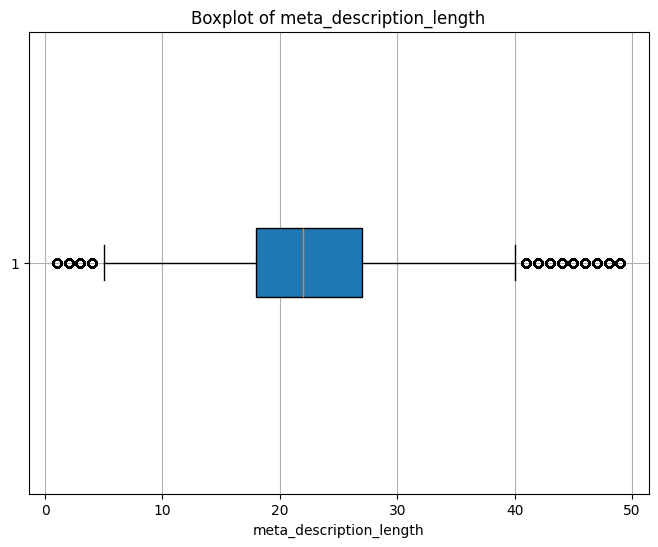

In [29]:
# boxplot wo outliers 
plot_boxplot(merged_company_data[merged_company_data['meta_description_length_outlier'] == False]['meta_description_length'])

count    53845.000000
mean        24.862476
std          7.998229
min         13.000000
25%         19.000000
50%         23.000000
75%         28.000000
max         48.000000
Name: meta_description_length, dtype: float64
(53845, 22)


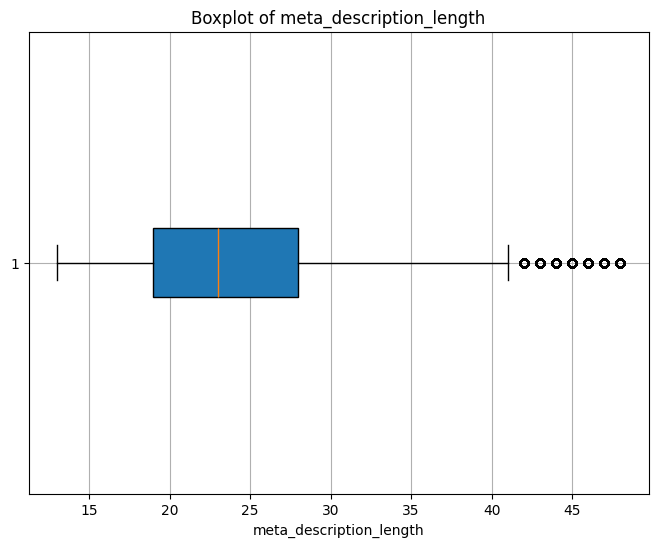

In [30]:
# filter out len outliers, keep those between 10th - 90th Percentile
filtered_merged_company_data = merged_company_data[(merged_company_data['meta_description_length'] >= tenth_percentile) & (merged_company_data['meta_description_length'] <= ninetieth_percentile)]
print(filtered_merged_company_data['meta_description_length'].describe())
print(filtered_merged_company_data.shape)

# boxplot after removing outliers outside of 10th and 90th percentile
plot_boxplot(filtered_merged_company_data['meta_description_length'])

count    53845.000000
mean         0.846386
std          0.110056
min          0.000000
25%          0.800000
50%          0.850000
75%          0.900000
max          1.000000
Name: meta_description_is_english, dtype: float64


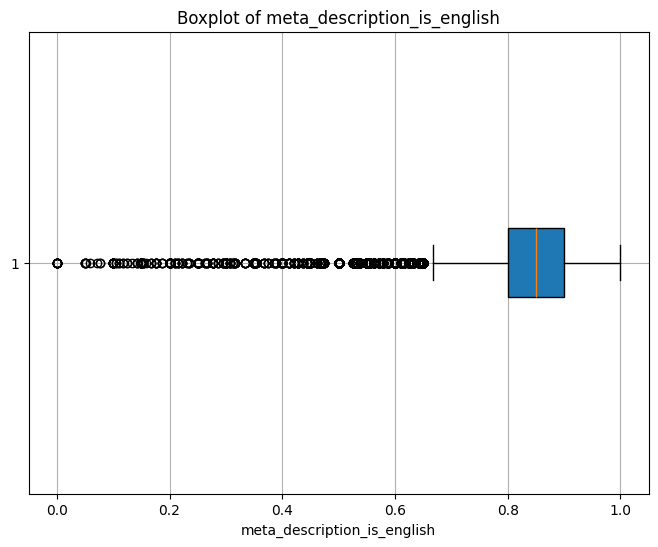

(265, 22)


id                       CompanyName              Website  \
62873  69555                ablecold logistics         ablecold.com   
59581  65899               aero consultants ag  aero-consultants.ch   
48277  53242             netbhet web solutions           netbhet.in   
40559  44617            andy kropa photography        andykropa.com   
53619  59278                  transport jaclin            jaclin.ca   
...      ...                               ...                  ...   
44517  49033                   phila news inc.     thephilanews.com   
42650  46953                    form-solutions    form-solutions.de   
65128  72058  aerodynamic trailer systems, llc        ats-green.com   
17642  19413                  terrell electric  terrellelectric.com   
55530  61411                    rush transport             relog.it   

                                  industry  current employee estimate  \
62873           logistics and supply chain                          3   
59581                 aviation & aerospace                          1   
48277  information technology and services                          1   
40559                          photography                          1   
53619     transportation/trucking/railroad                          6   
...                                    ...                        ...   
44517                           newspapers                          3   
42650  information technology and services                          1   
65128     transportation/trucking/railroad                          0   
17642                         construction                          0   
55530     transportation/trucking/railroad                          8   

       total employee estimate  year founded size range         country  \
62873                        3          2017     1 - 10           india   
59581                        1             0     1 - 10  united kingdom   
48277                        1          2009     1 - 10           india   
40559                        1             0     1 - 10   united states   
53619                        8             0    11 - 50          canada   
...                        ...           ...        ...             ...   
44517                        7          1995     1 - 10   united states   
42650                        5             0     1 - 10   united states   
65128                        1             0     1 - 10   united states   
17642                        1             0     1 - 10   united states   
55530                       13             0    11 - 50   united states   

                                           locality  ...  \
62873                   bengaluru, karnataka, india  ...   
59581  wolverhampton, wolverhampton, united kingdom  ...   
48277                    bombay, maharashtra, india  ...   
40559             brooklyn, new york, united states  ...   
53619                   contrecoeur, quebec, canada  ...   
...                                             ...  ...   
44517     philadelphia, pennsylvania, united states  ...   
42650               elkhart, indiana, united states  ...   
65128                   auburn, ohio, united states  ...   
17642                   kosse, texas, united states  ...   
55530               joliet, illinois, united states  ...   

                                           homepage_text  \
62873  Home Customers Partners About Us Careers Blog ...   
59581  Home Unternehmen Geschichte Verhaltenskodex Qu...   
48277  Home About Contact Us Sitemap Error Page Home ...   
40559  HOME ABOUT US PARENT PAGE SUB PAGE Andykropa.c...   
53619  FR EN Ouvrir Fermer le Menu Demande de taux Re...   
...                                                  ...   
44517  viagra online These websites will probably be ...   
42650  Springe zur Navigation mit der Eingabetaste be...   
65128  ABKAI 市川海老蔵オフィシャルブログ Powered by Ameba ABKAI 市川...   
17642  Skip to content HOME SERVICES ABOUT WORK BLOG ...  

In [40]:
# non-english meta descriptions
print(filtered_merged_company_data['meta_description_is_english'].describe())
plot_boxplot(filtered_merged_company_data['meta_description_is_english'])
# EXPORT 
print(filtered_merged_company_data[filtered_merged_company_data['meta_description_is_english'] < 0.35].shape)
filtered_merged_company_data[filtered_merged_company_data['meta_description_is_english'] < 0.35].sort_values(by='meta_description_is_english', ascending=False).to_excel('../outputs/non_eng_meta_desc.xlsx', index = False)
filtered_merged_company_data[filtered_merged_company_data['meta_description_is_english'] < 0.35].sort_values(by='meta_description_is_english', ascending=False)

In [41]:
# filter those over 35% 
filtered_merged_company_data = filtered_merged_company_data[filtered_merged_company_data['meta_description_is_english'] >= 0.35]
filtered_merged_company_data.shape

(53580, 22)

In [43]:
# Step 1: Group by meta_description and count unique Categories in each group
category_counts = filtered_merged_company_data.groupby('meta_description')['Category'].nunique().reset_index()

# Step 2: Rename the column for clarity
category_counts = category_counts.rename(columns={'Category': 'unique_category_count'})

# Step 3: Identify meta_descriptions to remove (where unique_category_count > 1)
meta_descriptions_to_remove = category_counts[category_counts['unique_category_count'] > 1]['meta_description']

# Step 4: Filter the original DataFrame to exclude these meta_descriptions
initial_row_count = len(filtered_merged_company_data)
filtered_merged_company_data = filtered_merged_company_data[~filtered_merged_company_data['meta_description'].isin(meta_descriptions_to_remove)]
final_row_count = len(filtered_merged_company_data)

# Step 5: Count the total rows removed
rows_removed = initial_row_count - final_row_count

print(f"Total rows removed: {rows_removed}")
filtered_merged_company_data

Total rows removed: 187


In [49]:
# handle remaining dups of same category
# 
# EXPORT

# Step 1: Sort the DataFrame by 'meta_description'
sorted_data = filtered_merged_company_data.sort_values(by='meta_description')

# Step 2: Count the initial number of rows
initial_row_count = len(filtered_merged_company_data)

# Step 3: Identify duplicates based on 'meta_description' and keep only the first occurrence
deduplicated_filtered_merged_company_data = filtered_merged_company_data[~filtered_merged_company_data.duplicated(subset='meta_description', keep='first')]

# Step 4: Count the final number of rows after deduplication
final_row_count = len(deduplicated_filtered_merged_company_data)

# Step 5: Calculate the number of rows removed
rows_removed = initial_row_count - final_row_count

# Display the resulting DataFrame and the count of removed rows
print(f"Total rows removed: {rows_removed}")
deduplicated_filtered_merged_company_data

Total rows removed: 433


id                       CompanyName                 Website  \
0          1         bip dipietro electric inc         bipelectric.com   
1          2                     elias medical        eliasmedical.com   
2          3              koops overhead doors  koopsoverheaddoors.com   
3          4                   midtown eyecare         midtowneyes.com   
4          5                repro security ltd     reprosecurity.co.uk   
...      ...                               ...                     ...   
66384  73442  afterglow beverage company, inc.         nutristicks.com   
66386  73445                   claddagh coffee  claddaghcoffeecafe.com   
66387  73446                     beautyologist    beautyologist.com.au   
66388  73447                       beauty call        beautycall.co.uk   
66389  73448                 little lady foods     littleladyfoods.com   

                          industry  current employee estimate  \
0                     construction                          0   
1                 medical practice                          3   
2                     construction                          1   
3                 medical practice                          1   
4      security and investigations                          1   
...                            ...                        ...   
66384             food & beverages                          1   
66386             food & beverages                          1   
66387                    cosmetics                          2   
66388                    cosmetics                          9   
66389              food production                        100   

       total employee estimate  year founded size range         country  \
0                            1          1998     1 - 10   united states   
1                            3             0     1 - 10   united states   
2                            1             0     1 - 10   united states   
3                            1             0     1 - 10   united states   
4                            1             0     1 - 10  united kingdom   
...                        ...           ...        ...             ...   
66384                        4             0     1 - 10   united states   
66386                        6             0     1 - 10   united states   
66387                        3             0     1 - 10       australia   
66388                       14          2006    11 - 50  united kingdom   
66389                      294          1984   51 - 200   united states   

                                                locality  ...  \
0                     vero beach, florida, united states  ...   
1                 bakersfield, california, united states  ...   
2                  averill park, new york, united states  ...   
3                         tulsa, oklahoma, united states  ...   
4      market harborough, leicestershire, united kingdom  ...   
...                                                  ...  ...   
66384          wilmington, north carolina, united states  ...   
66386           san francisco, california, united states  ...   
66387                    vitoria, espirito santo, brazil  ...   
66388             london, greater london, united kingdom  ...   
66389         elk grove village, illinois, united states  ...   

                                           homepage_text  \
0      Electricians and electrical contractors servin...   
1      site map en español Elias Medical home about u...   
2      Home About Us Garage Door Repair Service Desig...   
3       Type Size: A A A Home Our Practice Our Servic...   
4      Simply fill out our form below and we will be ...   
...                                                  ...   
66384  Home Products About Me FAQ Contact Think about...   
66386  Home About Us Our Shops West Seventh Wee Shop ...   
66387   Make A Booking Beautyologist Beauty Salon Sho...   
66388  Enquire now Get in touch Gallery Prices Review...  

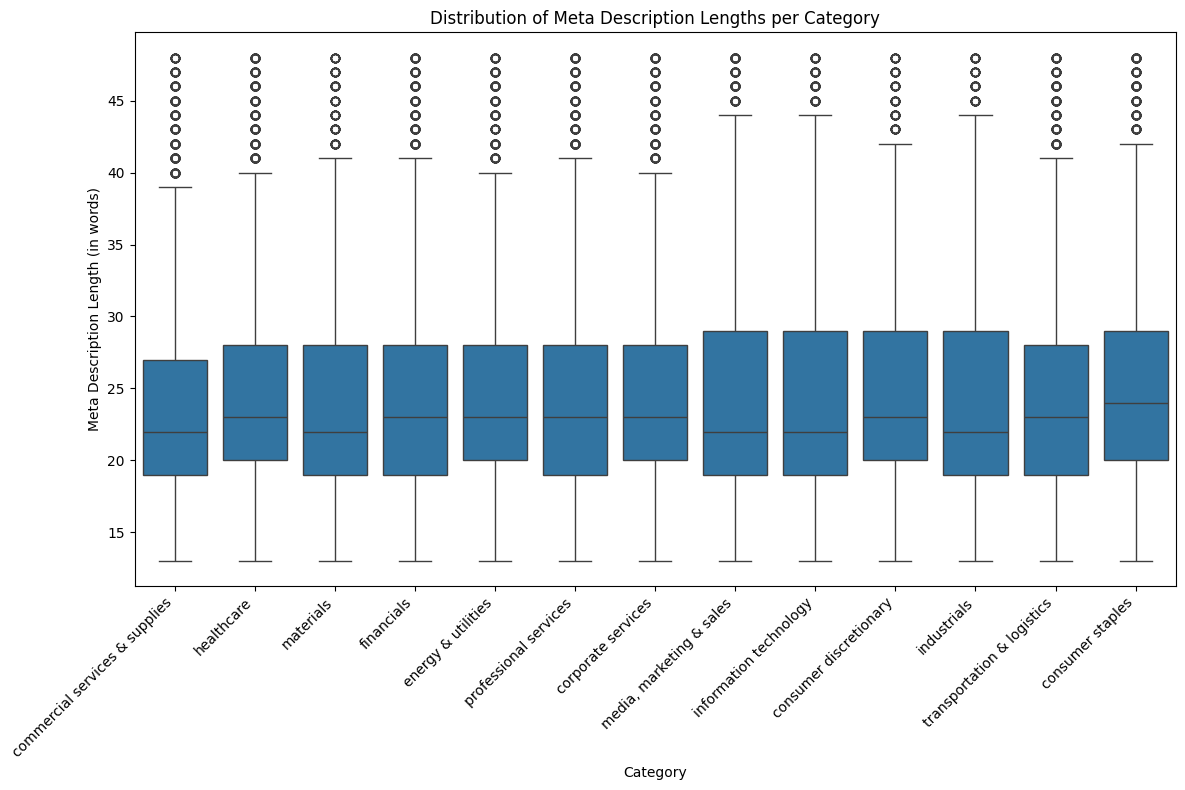

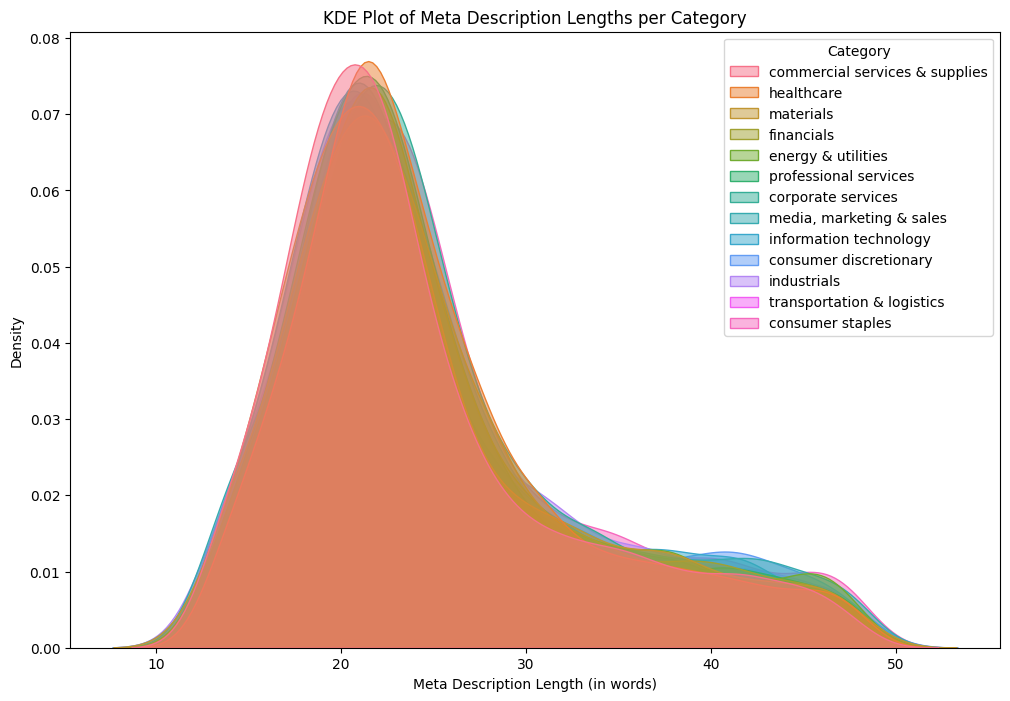

In [52]:
# visualize distribution of meta_descriptions & meta_description_lengths per Category 

# Plot boxplot of meta description lengths per category
plot_boxplot_meta_description_length(
    data=deduplicated_filtered_merged_company_data,
    category_col='Category',
    length_col='meta_description_length'
)

# Plot KDE of meta description lengths per category
plot_kde_meta_description_length(
    data=deduplicated_filtered_merged_company_data,
    category_col='Category',
    length_col='meta_description_length'
)


/var/folders/b0/2l0p5l0x0t1fdt783fbrq18h0000gn/T/ipykernel_81483/3995347910.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis")


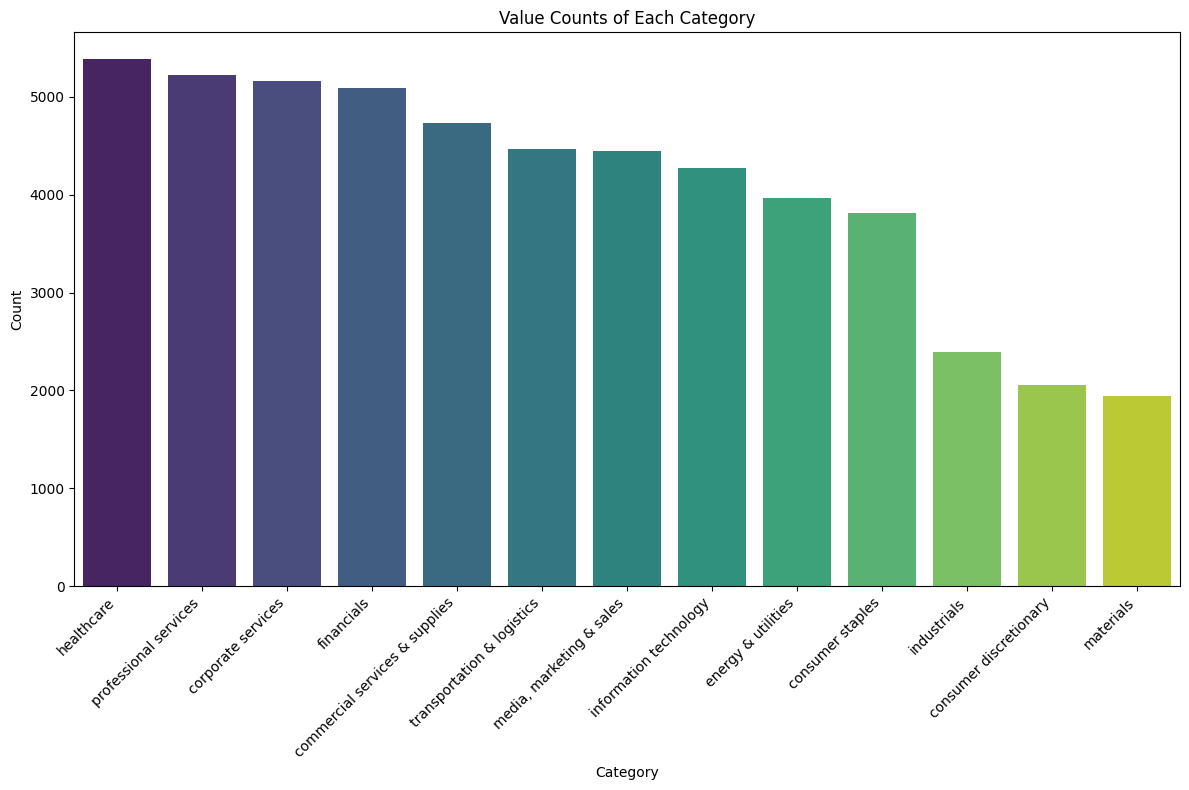

In [54]:
# Plot value counts of each category
plot_category_value_counts(
    data=deduplicated_filtered_merged_company_data,
    category_col='Category'
)


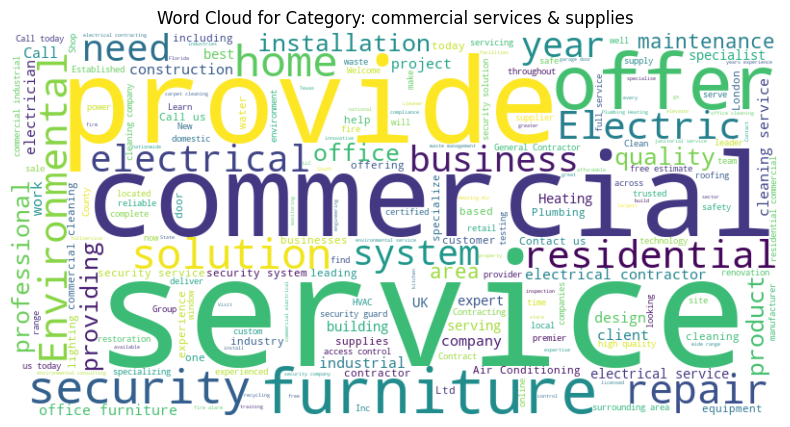

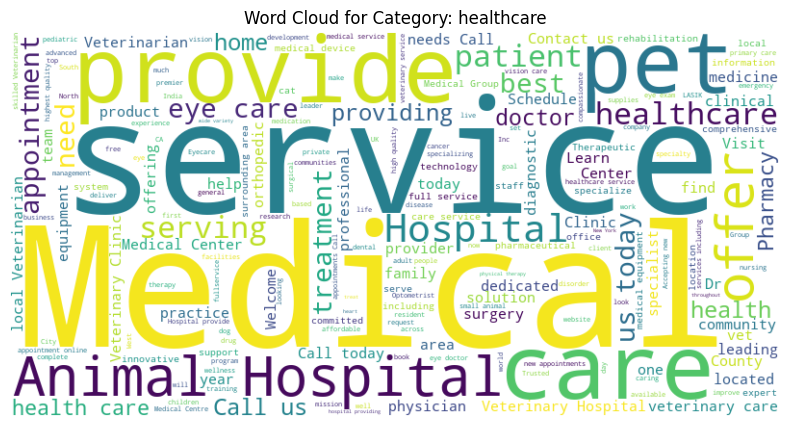

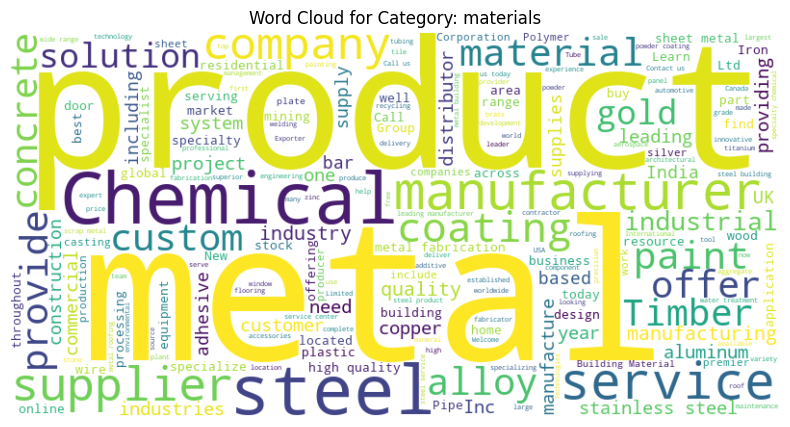

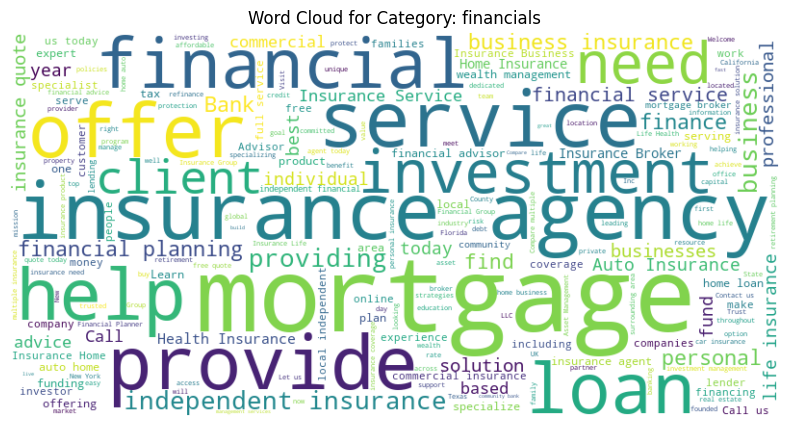

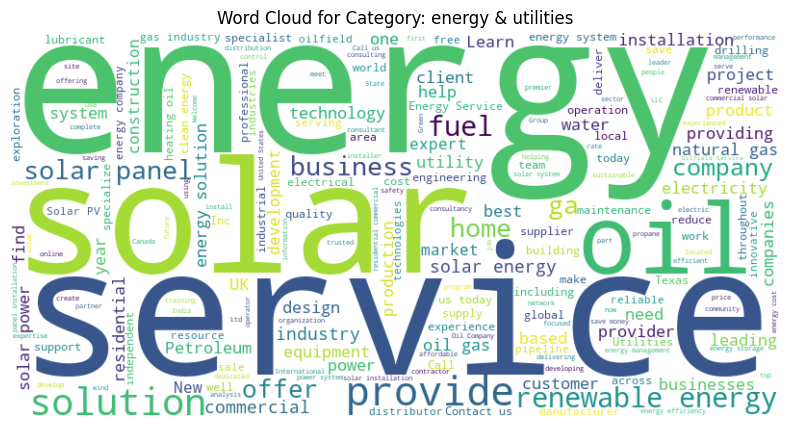

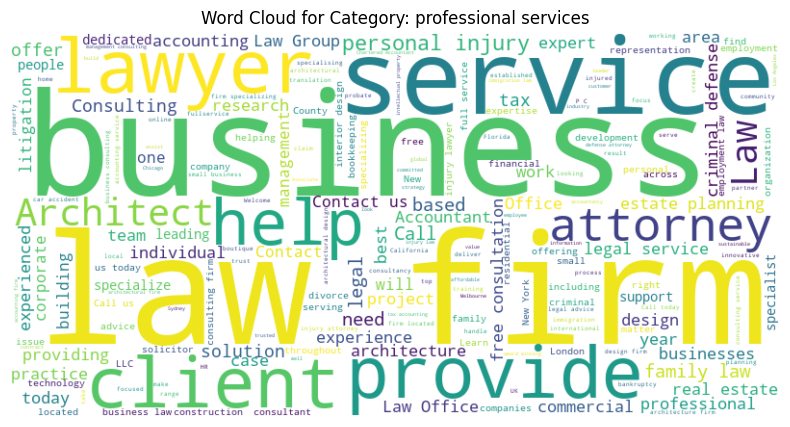

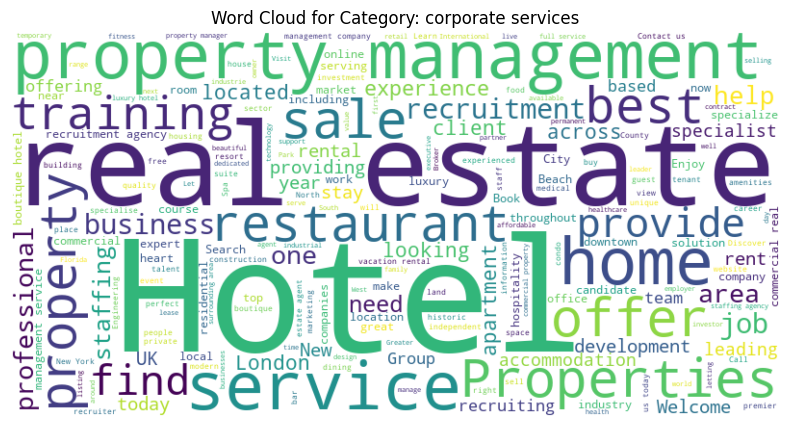

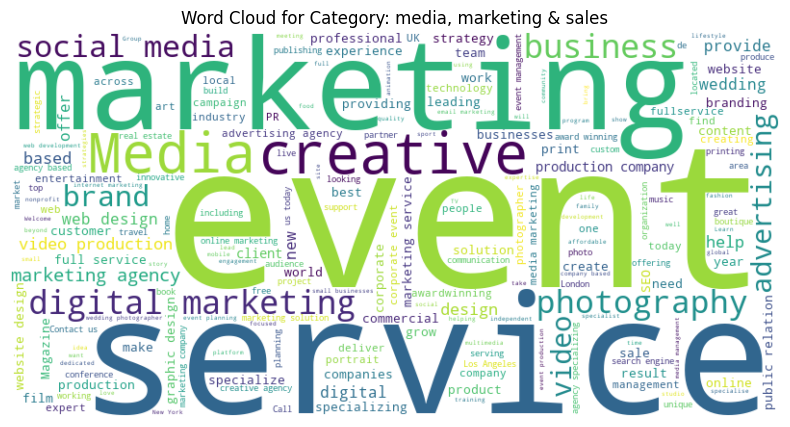

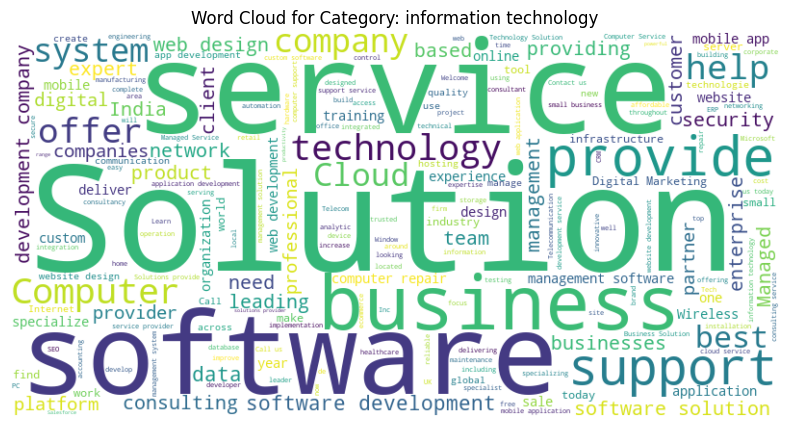

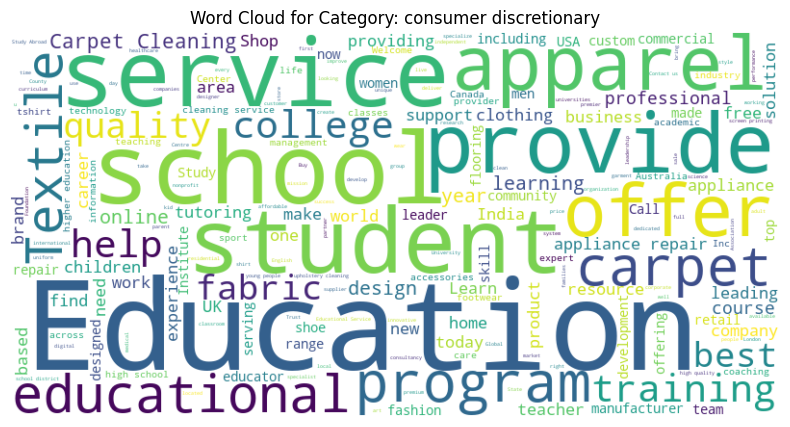

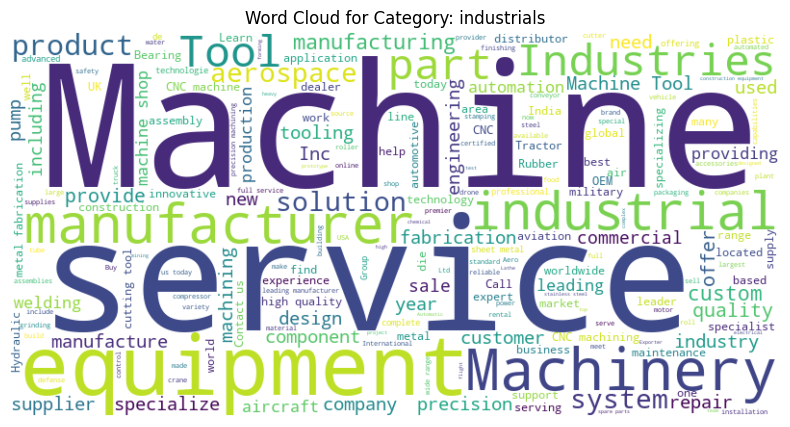

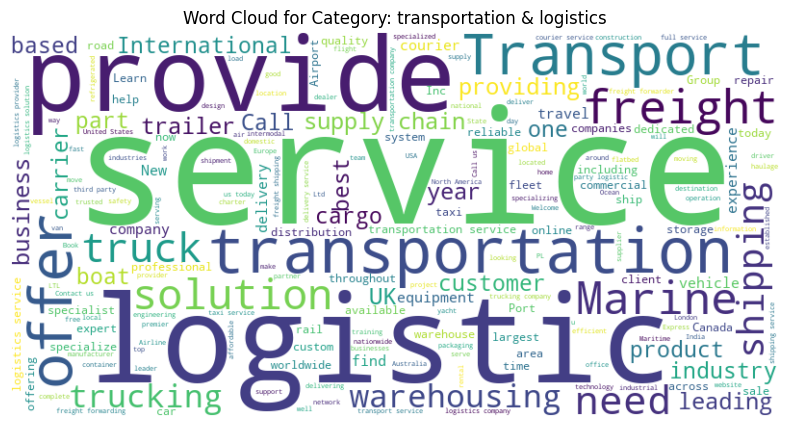

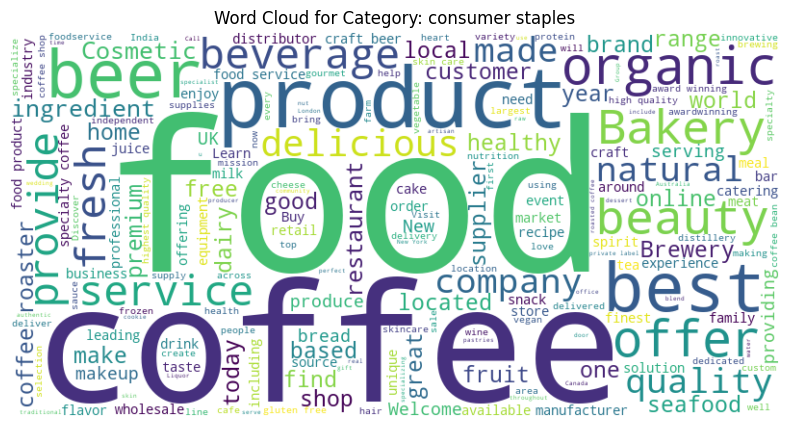

In [57]:
# Generate word clouds per category
generate_wordclouds_per_category(
    data=deduplicated_filtered_merged_company_data,
    category_col='Category',
    text_col='meta_description'
)

In [60]:
# Generate TF-IDF top terms per category
tfidf_top_terms(
    data=deduplicated_filtered_merged_company_data,
    category_col='Category',
    text_col='meta_description',
    top_n=10  # Adjust this to get more or fewer top terms
)



Top 10 TF-IDF terms for Category: commercial services & supplies
                    tfidf
services       161.877941
security       152.282646
electrical     143.340724
commercial     122.122276
cleaning       119.534769
furniture      109.865778
service         96.570344
office          93.022488
environmental   78.120601
company         76.348509

Top 10 TF-IDF terms for Category: healthcare
                 tfidf
care        214.458248
medical     185.186939
hospital    163.720254
veterinary  138.605793
services    128.477903
eye         123.268029
health      110.878326
animal      105.205100
today       101.772084
healthcare   98.881895

Top 10 TF-IDF terms for Category: materials
                tfidf
steel       74.916725
metal       58.856679
products    50.087167
chemical    36.087732
chemicals   34.630723
company     32.276218
metals      31.552089
quality     31.414396
materials   26.705936
industrial  26.564611

Top 10 TF-IDF terms for Category: financials
                

In [61]:
deduplicated_filtered_merged_company_data.to_csv('../outputs/deduplicated_filtered_merged_company_data.csv', index=False)